In [144]:
import pandas as pd
from smartsheet_dataframe import get_as_df
import os

In [145]:
# Storing Smartsheet information in variables
shitz_token = "wMvGniITjDFd7ClZPE44wtJGvZkM7Hg7mP7if" #Bily's personal token to access G-A smartsheet data. Anyone can obtain their own token
fhaid = 4523924143794052 # The ID number that references the FHA sheet
mssid = 3005704744265604 # The ID number that references the MSS sheet

# Creating the FHA and MSS dataframes
fha_df = get_as_df(type_='sheet',
                  token=shitz_token,
                  id_=fhaid)

mss_df = get_as_df(type_='sheet',
                  token=shitz_token,
                  id_=mssid)

# data_df = mss_df.loc[(mss_df['UniqueID'].str.contains('WAR')) |
#                     (mss_df['UniqueID'].str.contains('WRR')) |
#                     (mss_df['UniqueID'].str.contains('BJT'))].copy()
data_df = mss_df.copy()

data_df['Tract'] = data_df['Tract'].astype(str).apply(lambda x: x.split('.')[0])
data_df['CMP'] = data_df['CMP'].astype(str).apply(lambda x: x.split('.')[0])
data_df['Stand'] = data_df['Stand'].astype(str).apply(lambda x: x.split('.')[0])
data_df['TCS'] = data_df['Tract'] + "_" + data_df['CMP'] + "_" + data_df['Stand']

data_df['Reporting Period'] = data_df['Reporting Period'].fillna(0)
data_df.loc[data_df['Reporting Period'] == "", 'Reporting Period'] = 0
data_df['Reporting Period'] = data_df['Reporting Period'].astype(str)
s = data_df.loc[pd.to_numeric(data_df['Reporting Period'], errors='coerce').isnull() & data_df['Reporting Period'].str.contains("RP"), 'Reporting Period'].apply(lambda x: x.strip()[-1])
data_df['trial'] = data_df.index.map(s)
data_df.loc[pd.to_numeric(data_df['Reporting Period'], errors='coerce').isnull() & data_df['Reporting Period'].str.contains("RP"), 'Reporting Period'] = data_df.loc[pd.to_numeric(data_df['Reporting Period'], errors='coerce').isnull() & data_df['Reporting Period'].str.contains("RP"), 'trial']
data_df['Reporting Period'] = pd.to_numeric(data_df['Reporting Period'], downcast='integer')
data_df['Future GT'] = pd.to_numeric(data_df['Future GT'], errors='coerce')


## Creaet Client Table

In [146]:
# Filter out the Client Provided data and make sure the fields are similar
client_df = data_df[['UniqueID',
                    'Tract',
                    'CMP',
                    'Stand',
                    'Acres',
                    'Age',
                    'County',
                    'State',
                    'Species',
                    'Origin',
                    'Scheduled',
                    'PreBA',
                    'PreTPA',
                    'PreGTA',
                    'PlnBA',
                    'PlnTPA',
                    'PlnGTA',
                    'Client GT',
                    'Future GT',
                    'Reporting Period']].copy()

client_df['Age'] = pd.to_numeric(client_df['Age'], errors='coerce', downcast='integer').fillna(0).astype(int)
client_df.loc[pd.to_numeric(client_df['Future GT'], errors='coerce').isnull(), 'Future GT'] = 0
client_df['Tract'] = client_df['Tract'].astype(str)
client_df['Stand'] = client_df['Stand'].astype(str)
client_df['Tract'] = client_df['Tract'].apply(lambda x: x.split('.')[0])
client_df['Client GT'] = pd.to_numeric(client_df['Client GT'], errors="coerce")
client_df['Client GT'] = client_df['Client GT'].fillna(0)

cols = ['PreBA', 'PreTPA', 'PreGTA', 'PlnBA', 'PlnTPA', 'PlnGTA']

for x in cols:
    client_df[x] = pd.to_numeric(client_df[x], errors='coerce', downcast='integer').fillna(-99).astype(int)



# Normalize some of the fields in the client intake table

## Normalize Species
species = ["Slash Pine", "Loblolly Pine", 'Mixed Natural Pine', 'Hardwood Mix', 'Pine Straw', "Other"]
species_dict = {'Species': species}
species_df = pd.DataFrame(species_dict)
species_df['Species_UID'] = species_df.index
species_df['Species'] = species_df['Species'].str.lower()

def species_map(x):
    x = x.lower()
    if "slash" in x:
        return 0
    elif "loblol" in x:
        return 1
    elif "mixed natural" in x:
        return 2
    elif "h" in x:
        return 3
    elif "straw" in x:
        return 4
    elif "pine" in x:
        return 1
    else:
        return 5
    
client_df['Species'] = client_df['Species'].apply(lambda x: species_map(x))


## Normalize origin
origins = ['Planted', 'Natural', 'Natural Mix', 'Other']
origin_dict = {'Origin': origins}
origin_df = pd.DataFrame(origin_dict)
origin_df['OriginUID'] = origin_df.index
origin_df['Origin'] = origin_df['Origin'].str.lower()

def origin_map(x):
    x = x.lower()
    if "plant" in x:
        return 0
    elif "natural mix" in x:
        return 2
    elif "nat" in x:
        return 1
    else:
        return 3
client_df['Origin'] = client_df['Origin'].apply(lambda x: origin_map(x))


## Normalize tract
client_df['tract_l'] = client_df['Tract'].apply(lambda x: x.lower())
tracts = client_df['tract_l'].unique().tolist()
tract_dict = {'tract': tracts}
tract_df = pd.DataFrame(tract_dict)
tract_df['tract_uid'] = tract_df.index
new_tract_dict = dict(zip(tract_df['tract'], tract_df['tract_uid']))
client_df['Tract'] = client_df['tract_l'].map(new_tract_dict)

## Normalize county
client_df['County'] = client_df['County'].astype(str)
client_df['county_l'] = client_df['County'].apply(lambda x: x.lower())
countys = client_df['county_l'].unique().tolist()
county_dict = {'county': countys}
county_df = pd.DataFrame(county_dict)
county_df['county_uid'] = county_df.index
new_county_dict = dict(zip(county_df['county'], county_df['county_uid']))
client_df['County'] = client_df['county_l'].map(new_county_dict)

## Normalize state
client_df['State'] = client_df['State'].astype(str)
client_df['state_l'] = client_df['State'].apply(lambda x: x.lower())
states = client_df['state_l'].unique().tolist()
state_dict = {'state': states}
state_df = pd.DataFrame(state_dict)
state_df['state_uid'] = state_df.index
new_state_dict = dict(zip(state_df['state'], state_df['state_uid']))
client_df['State'] = client_df['state_l'].map(new_state_dict)

# Drop the lowercase columns
client_df.drop(columns=['tract_l', 'county_l', 'state_l'], inplace=True)


## Create GA Intake Table

In [147]:
ga_intake_df = data_df[['IntakeID',
                       'FolderID',
                       'UniqueID',
                       'GA_ACRES',
                       'GA GT', # this is going to be GA total isn't it? Or does it stay as GA estimate of current GT (total minus what client says is future)
                       'Total GT', # This will be the conservative total between client and GA numbers
                       'Notes'
                       ]].copy()

# Lowercase the ga_intake_df column names
ga_intake_df.columns = [x.lower().replace(' ', '_') for x in ga_intake_df.columns]
ga_intake_df.rename(columns={'uniqueid': 'ga_uid'},inplace=True)
ga_intake_df = ga_intake_df[['ga_uid', 'intakeid', 'folderid', 'ga_acres', 'ga_gt', 'total_gt', 'notes']]


## Create Status Table

In [148]:
status_df = data_df[['UniqueID',
                    'Guidance',
                    'Expiration',
                    'GuidanceProvider',
                    'Status',
                    'Completed Date'
                    ]].copy()
status_df.rename(columns={'UniqueID': 'status_uid'}, inplace=True)

## Create TicketID -> UniqueID lookup table

In [149]:
ticketid_lookup_df = data_df[['UniqueID', 'TicketID']].copy() # the uniqueid will the the unique id for this table


In [150]:
ticketid_list = data_df['TicketID'].unique().tolist()
ticketid_dict = {'ticketid': ticketid_list}
ticketid_df = pd.DataFrame(ticketid_dict)
ticketid_df['ticketid_uid'] = ticketid_df.index
new_ticketid_dict = dict(zip(ticketid_df['ticketid'], ticketid_df['ticketid_uid']))
ticketid_lookup_df['ticketid'] = ticketid_lookup_df['TicketID'].map(new_ticketid_dict)

ticketid_lookup_df.rename(columns={'ticketid_uid': 'ticket_id',
                                    'UniqueID': 'ticket_lookup_uid'}, inplace=True)
ticketid_lookup_df.drop('TicketID', axis=1, inplace=True)

In [151]:
ticketid_lookup_df

,ticket_lookup_uid,ticketid
0,WAR241025HD09,0
1,WAR241025HD07,0
2,WAR241025HD06,0
3,WAR250620TH02,1
4,WAR250310BI03,2
...,...,...
840,WRR240109TT01,578
841,WRR240325BN01,579
842,WRR240318BN02,580
843,WRR240318BN01,581


## Create the TCS lookup


In [152]:
tcs_df = data_df.groupby('TicketID').agg({'Tract': 'first',
                                               'CMP': 'first',
                                               'Stand': ', '.join}).reset_index()

def split_stands(x):
    bugger_splot = list(set(x.split(', ')))
    bugger_splot.sort()
    return ", ".join(bugger_splot)
    
tcs_df['stands'] = tcs_df['Stand'].apply(split_stands)
tcs_df['comp'] = tcs_df['CMP'].apply(lambda x: x if x!="NP" else "")
tcs_df['TCS'] = tcs_df['Tract'] + "_" + tcs_df['comp'] + "_" + tcs_df['stands']
tcs_df['TCS'] = tcs_df['TCS'].apply(lambda x: x.replace("__", "_"))
tcs_df['tcs_uid'] = tcs_df.index
tcs_df = tcs_df[['tcs_uid', 'TicketID', 'TCS']].copy()

TicketID table should have a link to this

In [153]:
tcs_mapper = dict(zip(tcs_df['TicketID'], tcs_df['tcs_uid']))
ticketid_df['tcs'] = ticketid_df['ticketid'].map(tcs_mapper)

In [154]:
ticketid_df[ticketid_df['tcs'].isna()]

,ticketid,ticketid_uid,tcs


## Create a projects table

In [155]:
a = "WAR250303XXXX"
a[:3]

'WAR'

In [156]:
mss_df['project'] = mss_df['UniqueID'].str[:3]
project_df = mss_df[['project']].drop_duplicates()
project_df.reset_index(inplace=True)
project_df['proj_uid'] = project_df.index
project_df = project_df[['project', 'proj_uid']]
project_df

,project,proj_uid
0,WAR,0
1,BJT,1
2,WRR,2
3,DLT,3
4,MFV,4
5,MLB,5
6,MID,6
7,BKG,7
8,,8


## Place the above tables into the Database
- [X] client_df
- [X] ga_intake_df
- [X] origin_df
- [X] county_df
- [X] species_df
- [X] state_df
- [X] status_df
- [X] tcs_df
- [X] ticketid_df
- [X] ticketid_lookup_df
- [X] tract_df

### Lowercase all of the column names

In [157]:
# Client table
## lowercase client_df field names
client_df.columns = [x.lower() for x in client_df.columns]
client_df.columns = [x.replace(' ', '_') for x in client_df.columns]
client_df['client_uid'] = client_df['uniqueid']
client_df.drop(columns=['uniqueid'],inplace=True)
client_df = client_df[['client_uid', 'tract', 'cmp', 'stand', 'acres', 'age', 'county', 'state', 'species', 'origin', 'scheduled', 'preba', 'pretpa', 'pregta',
                       'plnba', 'plntpa', 'plngta', 'client_gt', 'future_gt', 'reporting_period']]

# ga_intake
ga_intake_df.columns = [x.lower().replace(' ', '_') for x in ga_intake_df.columns]
ga_intake_df = ga_intake_df[['ga_uid', 'intakeid', 'folderid', 'ga_acres', 'ga_gt', 'total_gt']]

# origin_df
origin_df.rename(columns={'OriginUID': 'origin_uid',
                          'Origin': 'origin'}, inplace=True)

# county_df
county_df.columns = [x.lower() for x in county_df.columns]

# species_df
species_df.columns = [x.lower() for x in species_df.columns]

# state_df
state_df.columns = [x.lower() for x in state_df.columns]

# status_df
status_df.columns = [x.lower() for x in status_df.columns]

# tcs_df
tcs_df.columns = [x.lower() for x in tcs_df.columns]

# ticketid_df
ticketid_df.columns = [x.lower() for x in ticketid_df.columns]

# ticketid_lookup_df
ticketid_lookup_df.columns = [x.lower() for x in ticketid_lookup_df.columns]

# tract_df
tract_df.columns = [x.lower() for x in tract_df.columns]



In [158]:
# define the db
import sqlite3

conn = sqlite3.connect(r'C:\Users\bbrown\Documents\python_scripts\db-build-trial\db_trial_v1\ga_harvest_round2.db')
c = conn.cursor()

In [159]:
### Update the DB

client_df.to_sql('client_intake', conn, if_exists='replace',index=False, dtype={'client_uid': 'TEXT PRIMARY KEY'})
ga_intake_df.to_sql('ga_intake', conn, if_exists='replace', index=False, dtype={'ga_uid': 'TEXT PRIMARY KEY'})
origin_df.to_sql('origin', conn, if_exists='replace', index=False, dtype={'origin_uid': 'INTEGER PRIMARY KEY'})
county_df.to_sql('county', conn, if_exists='replace', index=False, dtype={'county_uid': 'INTEGER PRIMARY KEY'})
species_df.to_sql('species', conn, if_exists='replace', index=False, dtype={'species_uid': 'INTEGER PRIMARY KEY'})
state_df.to_sql('state', conn, if_exists='replace', index=False, dtype={'state_uid': 'INTEGER PRIMARY KEY'})
status_df.to_sql('status', conn, if_exists='replace', index=False, dtype={'status_uid': 'TEXT PRIMARY KEY'})
tcs_df.to_sql('tcs', conn, if_exists='replace', index=False, dtype={'tcs_uid': 'INTEGER PRIMARY KEY'})
ticketid_df.to_sql('ticketid', conn, if_exists='replace', index=False, dtype={'ticketid_uid': 'INTEGER PRIMARY KEY'})
ticketid_lookup_df.to_sql('ticketid_lookup_activityid', conn, if_exists='replace', index=False, dtype={'ticketid_lookup_uid': 'TEXT PRIMARY KEY'})
tract_df.to_sql('tract', conn, if_exists='replace', index=False, dtype={'tract_uid':'INTEGER PRIMARY KEY'})
project_df.to_sql('project', conn, if_exists='replace', index=False, dtype={'proj_uid':'INTEGER PRIMARY KEY'})


9

# Mill Ticket sections

In [160]:
projs = ['WAR', 'WRR', 'BJT', 'DLT', 'MLB', 'BKG', 'MID']

In [161]:
mill_loc = r"P:\Mill Tickets"
mega_df = pd.DataFrame()

for proj in projs:
    file_pattern = f"{proj}_RP*_Compiled.xlsm"
    big_df = pd.DataFrame()

    mill_name = []
    for root, dirs, files in os.walk(mill_loc):
        for file in files:
            if f"{proj}_RP" in file and file.endswith("Compiled.xlsm"):
                if "$" in file:
                    pass
                else:
                    print(root)
                    print(file)
                    df = pd.read_excel(os.path.join(root, file), sheet_name='RP_Project')
                    big_df = pd.concat([big_df, df])
    mega_df = pd.concat([mega_df, big_df])
                    
'''
    big_df.loc[big_df['Tons (U.S)'].isnull(), 'Tons (U.S)'] = big_df.loc[big_df['Tons (U.S)'].isnull(), 'TonsUS']
    big_df['Cull Tons'].fillna(big_df['CullTons'], inplace=True)
    big_df['Accepted Tons'].fillna(big_df['AcceptedTons'], inplace=True)
    big_df['Reporting Period'].fillna(big_df['ReportingPeriod'],inplace=True)

    def rep_fix(x):
        if "RP" in str(x):
            return x[-1]
        else:
            return x
        
    big_df['Reporting Period'] = big_df['Reporting Period'].apply(lambda x: rep_fix(x))
    big_df['Reporting Period'] = pd.to_numeric(big_df['Reporting Period'])

    big_df['Date'] = pd.to_datetime(big_df['Date'])

    harvest_df = big_df[['Date',
                    'Ticket',
                    'Mill',
                    'Product',
                    'Tons (U.S)',
                    'Cull Tons',
                    'Accepted Tons',
                    'Source',
                    'Notes',
                    'Reporting Period',
                    'TicketID',
                    'Week']].copy()

    harvest_df = harvest_df.drop_duplicates()
    '''

P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\WAR\WAR_RP2
WAR_RP2_Compiled.xlsm


c:\Users\bbrown\Anaconda3\envs\postgres_python\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\WAR\WAR_RP3
WAR_RP3_Compiled.xlsm


c:\Users\bbrown\Anaconda3\envs\postgres_python\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\WAR\WAR_RP4
WAR_RP4_Compiled.xlsm


c:\Users\bbrown\Anaconda3\envs\postgres_python\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\WAR\WAR_RP5
WAR_RP5_Compiled.xlsm


c:\Users\bbrown\Anaconda3\envs\postgres_python\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


P:\Mill Tickets\ARCHIVE\WAR_RP6
WAR_RP6_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\WAR_RP7
WAR_RP7_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\WAR_RP8
WAR_RP8_Compiled.xlsm
P:\Mill Tickets\WAR_RP10
WAR_RP10_Compiled.xlsm
P:\Mill Tickets\WAR_RP9
WAR_RP9_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\WRR\RP1
WRR_RP1_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\WRR_RP5
WRR_RP5_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\WRR_RP6
WRR_RP6_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\WRR_RP7
WRR_RP7_Compiled.xlsm
P:\Mill Tickets\WRR_RP8
WRR_RP8_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\BJT_RP5
BJT_RP5_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\BJT_RP6
BJT_RP6_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\BJT_RP7
BJT_RP7_Compiled.xlsm


C:\Users\bbrown\AppData\Local\Temp\ipykernel_21380\2111848845.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat([big_df, df])


P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\BJT\BJT_RP1_FinalMillTix\BJT_RP1_FinalMillTix
BJT_RP1_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\BJT\RP3
BJT_RP3_Compiled.xlsm
P:\Mill Tickets\BJT_RP8
BJT_RP8_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\DLT_RP1
DLT_RP1_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\DLT_RP2
DLT_RP2_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\DLT_RP3
DLT_RP3_Compiled.xlsm
P:\Mill Tickets\DLT_RP4
DLT_RP4_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\MLB_RP8
MLB_RP8_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\MLB_RP9
MLB_RP9_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\MLB\RP3
MLB_RP3_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\MLB\RP4
MLB_RP4_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\MLB\RP5
MLB_RP5_Compiled.xlsm
P:\Mill Tickets\MLB_RP10
MLB_RP10_Compiled.xlsm
P:\Mill Tickets\BKG_RP11
BKG_RP11_Compiled.xlsm
P:\Mill Tickets\MID_RP9
MID_RP9_Compiled.xlsm


'\n    big_df.loc[big_df[\'Tons (U.S)\'].isnull(), \'Tons (U.S)\'] = big_df.loc[big_df[\'Tons (U.S)\'].isnull(), \'TonsUS\']\n    big_df[\'Cull Tons\'].fillna(big_df[\'CullTons\'], inplace=True)\n    big_df[\'Accepted Tons\'].fillna(big_df[\'AcceptedTons\'], inplace=True)\n    big_df[\'Reporting Period\'].fillna(big_df[\'ReportingPeriod\'],inplace=True)\n\n    def rep_fix(x):\n        if "RP" in str(x):\n            return x[-1]\n        else:\n            return x\n        \n    big_df[\'Reporting Period\'] = big_df[\'Reporting Period\'].apply(lambda x: rep_fix(x))\n    big_df[\'Reporting Period\'] = pd.to_numeric(big_df[\'Reporting Period\'])\n\n    big_df[\'Date\'] = pd.to_datetime(big_df[\'Date\'])\n\n    harvest_df = big_df[[\'Date\',\n                    \'Ticket\',\n                    \'Mill\',\n                    \'Product\',\n                    \'Tons (U.S)\',\n                    \'Cull Tons\',\n                    \'Accepted Tons\',\n                    \'Source\',\n     

In [162]:
mega_df.loc[mega_df['Tons (U.S)'].isnull(), 'Tons (U.S)'] = mega_df.loc[mega_df['Tons (U.S)'].isnull(), 'TonsUS']
mega_df['Cull Tons'].fillna(mega_df['CullTons'], inplace=True)
mega_df['Accepted Tons'].fillna(mega_df['AcceptedTons'], inplace=True)
mega_df['Reporting Period'].fillna(mega_df['ReportingPeriod'],inplace=True)

def rep_fix(x):
    if "RP" in str(x):
        return x.replace("RP", "")
    else:
        return x
    
mega_df['Reporting Period'] = mega_df['Reporting Period'].apply(lambda x: rep_fix(x))
mega_df['Reporting Period'] = pd.to_numeric(mega_df['Reporting Period'])

mega_df['Date'] = pd.to_datetime(mega_df['Date'])

harvest_df = mega_df[['Date',
                'Ticket',
                'Mill',
                'Product',
                'Tons (U.S)',
                'Cull Tons',
                'Accepted Tons',
                'Source',
                'Notes',
                'Reporting Period',
                'TicketID',
                'Week']].copy()

harvest_df = harvest_df.drop_duplicates(subset=['Date', 'Ticket', 'Tons (U.S)', 'Mill', 'Cull Tons', 'Accepted Tons', 'TicketID'], keep='first')
harvest_df.loc[harvest_df['TicketID'] == 'WAR18051XXXX', 'TicketID'] = 'WAR180518XXXX' # Found some mislabeled tickets
harvest_df.reset_index(inplace=True)

In [163]:
# Find duplicated tickets based that are duplicated because of reporting period
dup_no_rp = harvest_df[harvest_df.duplicated(subset=['Date', 'Ticket', 'Tons (U.S)', 'Mill', 'Cull Tons', 'Accepted Tons'], keep=False)]

In [164]:
dup_no_rp.sort_values(by=['Ticket'])

,index,Date,Ticket,Mill,Product,Tons (U.S),Cull Tons,Accepted Tons,Source,Notes,Reporting Period,TicketID,Week


In [165]:
harvest_df.loc[harvest_df['TicketID'].str.contains("MLB"), 'Reporting Period'].unique()

array([ 8,  9,  3,  4,  5, 10], dtype=int64)

In [166]:
harvest_df[harvest_df["Reporting Period"] == 0]

,index,Date,Ticket,Mill,Product,Tons (U.S),Cull Tons,Accepted Tons,Source,Notes,Reporting Period,TicketID,Week


In [167]:
harvest_df.loc[(harvest_df['TicketID'].str.contains("WAR"))]

,index,Date,Ticket,Mill,Product,Tons (U.S),Cull Tons,Accepted Tons,Source,Notes,Reporting Period,TicketID,Week
0,0,2018-04-02,559174,International Paper 70980 - Rome Mill Fiber,Pulpwood,29.13,0.00,29.13,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,WAR180206TH02,1
1,1,2018-04-03,559404,International Paper 70980 - Rome Mill Fiber,Pulpwood,28.36,0.00,28.36,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,WAR180206TH02,1
2,2,2018-04-06,560824,International Paper 70980 - Rome Mill Fiber,Pulpwood,30.21,0.00,30.21,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,WAR180206TH02,1
3,3,2018-04-04,559994,International Paper 70980 - Rome Mill Fiber,Pulpwood,29.31,0.00,29.31,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,WAR180206TH02,1
4,4,2018-04-04,559849,International Paper 70980 - Rome Mill Fiber,Pulpwood,31.89,0.00,31.89,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,WAR180206TH02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48742,13960,2025-06-23,2098488,PCA - Clyattville,PPW,27.91,0.25,27.66,2025 Clinch hurricane wk 25 settlements.pdf,NaN,9,WAR241025HDXZ,Week01
48743,13961,2025-06-23,2098420,PCA - Clyattville,PPW,31.11,0.00,31.11,2025 Clinch hurricane wk 25 settlements.pdf,NaN,9,WAR241025HDXZ,Week01
48744,13962,2025-06-23,2098472,PCA - Clyattville,PPW,28.92,0.00,28.92,2025 Clinch hurricane wk 25 settlements.pdf,NaN,9,WAR241025HDXZ,Week01
48745,13963,2025-06-23,2098445,PCA - Clyattville,PPW,28.02,0.00,28.02,2025 Clinch hurricane wk 25 settlements.pdf,NaN,9,WAR241025HDXZ,Week01


In [168]:
harvest_df.to_excel("ticket_all.xlsx")

In [169]:
harvest_df.loc[harvest_df['TicketID'].str.contains("DLT"), 'Reporting Period'].unique().tolist()

[1, 2, 3, 4]

In [170]:
harvest_df.loc[(harvest_df['TicketID'].str.contains("WAR")) & (harvest_df['Reporting Period'] == 9), 'Tons (U.S)'].sum()

423370.725

In [171]:
harvest_war_df = harvest_df.loc[(harvest_df['TicketID'].str.contains("WAR"))].copy()
harvest_war_df.sort_values(by="Date", inplace=True)
harvest_war_df['tons_cumsum'] = harvest_war_df['Tons (U.S)'].cumsum()

<Axes: xlabel='Date'>

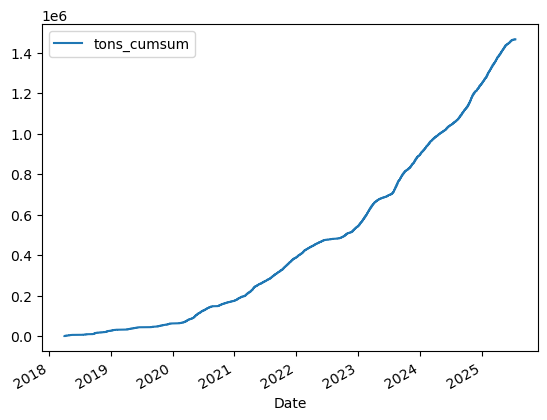

In [172]:
harvest_war_df.plot(x='Date', y='tons_cumsum')

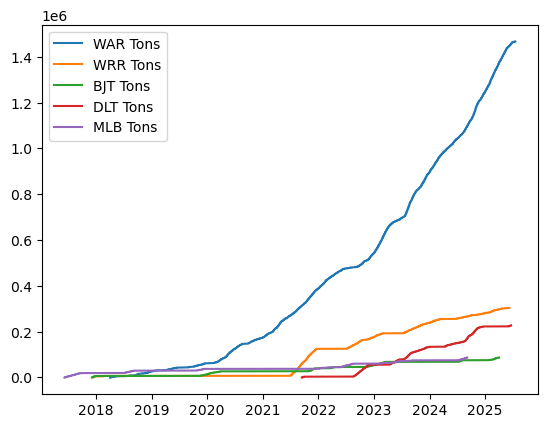

In [173]:
import matplotlib.pyplot as plt
war_harvest = harvest_df.loc[(harvest_df['TicketID'].str.contains("WAR"))].copy()
wrr_harvest = harvest_df.loc[(harvest_df['TicketID'].str.contains("WRR"))].copy()
bjt_harvest = harvest_df.loc[(harvest_df['TicketID'].str.contains("BJT"))].copy()
dlt_harvest = harvest_df.loc[harvest_df['TicketID'].str.contains("DLT")].copy()
mlb_harvest = harvest_df.loc[harvest_df['TicketID'].str.contains("MLB")].copy()
war_harvest = war_harvest.sort_values(by="Date")
wrr_harvest = wrr_harvest.sort_values(by="Date")
bjt_harvest = bjt_harvest.sort_values(by="Date")
dlt_harvest = dlt_harvest.sort_values(by="Date")
mlb_harvest = mlb_harvest.sort_values(by="Date")
war_harvest['tons_cumsum'] = war_harvest['Tons (U.S)'].cumsum()
wrr_harvest['tons_cumsum'] = wrr_harvest['Tons (U.S)'].cumsum()
bjt_harvest['tons_cumsum'] = bjt_harvest['Tons (U.S)'].cumsum()
dlt_harvest['tons_cumsum'] = dlt_harvest['Tons (U.S)'].cumsum()
mlb_harvest['tons_cumsum'] = mlb_harvest['Tons (U.S)'].cumsum()

fig, ax = plt.subplots()
ax.plot(war_harvest['Date'], war_harvest['tons_cumsum'], label='WAR Tons')
ax.plot(wrr_harvest['Date'], wrr_harvest['tons_cumsum'], label='WRR Tons')
ax.plot(bjt_harvest['Date'], bjt_harvest['tons_cumsum'], label='BJT Tons')
ax.plot(dlt_harvest['Date'], dlt_harvest['tons_cumsum'], label='DLT Tons')
ax.plot(mlb_harvest['Date'], mlb_harvest['tons_cumsum'], label="MLB Tons")
ax.legend()


In [174]:
harvest_df['project'] = harvest_df['TicketID'].str[:3]

In [175]:
harvest_df.groupby(["Reporting Period", 'project'])['Tons (U.S)'].sum()

Reporting Period  project
1                 BJT          6561.16000
                  DLT          3477.90000
                  WRR          6742.35000
2                 DLT         52145.25700
                  WAR          5473.11000
3                 BJT         20241.83000
                  DLT         78300.46859
                  MLB         19253.11000
                  WAR         37813.91000
4                 DLT         93668.79700
                  MLB         10645.96000
                  WAR         79671.06000
5                 BJT         18764.73000
                  MLB          7667.55900
                  WAR        145187.66000
                  WRR        118104.55000
6                 BJT         22554.64300
                  WAR        207275.13000
                  WRR         67942.98000
7                 WAR        216788.76000
                  WRR         63343.45800
8                 BJT         18822.38600
                  MLB         22710.39700
        

In [176]:
harvest_df['year'] = harvest_df['Date'].dt.year

<Axes: xlabel='project'>

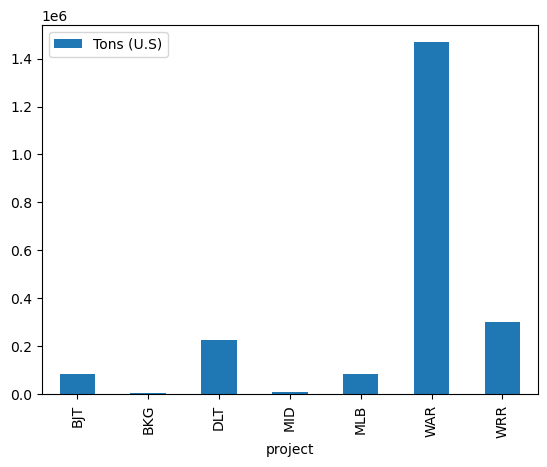

In [177]:
year_tons = harvest_df.groupby(['year', 'project'])['Tons (U.S)'].sum().reset_index()
year_tons.groupby('project')['Tons (U.S)'].sum().reset_index().plot(kind='bar', x='project', y='Tons (U.S)')

In [178]:
harvest_df.columns

Index(['index', 'Date', 'Ticket', 'Mill', 'Product', 'Tons (U.S)', 'Cull Tons',
       'Accepted Tons', 'Source', 'Notes', 'Reporting Period', 'TicketID',
       'Week', 'project', 'year'],
      dtype='object')

In [179]:
mill_list = harvest_df['Mill'].unique().tolist()
mill_dict = {}
mill_dict['mill'] = mill_list
mill_df = pd.DataFrame(mill_dict)
mill_df['mill_uid'] = mill_df.index
mill_mapper = dict(zip(mill_df['mill'], mill_df['mill_uid']))
harvest_df['mill'] = harvest_df['Mill'].map(mill_mapper)
harvest_df.drop(columns=['Mill'], inplace=True)

In [180]:
harvest_df['Week'] = harvest_df['Week'].astype(str)
harvest_df.loc[harvest_df['Week'] == 'Week3b', 'Week'] = "3"
harvest_df.loc[harvest_df['Week'] == 'Week2B', 'Week'] = "2"
def weeker(week):
    if "Week" in week:
        x = week.split("k")[1]
        x = int(x)
        return x
    elif "nan" in week:
        return 0
    else:
        return int(week)
    
harvest_df['Week_trial'] = harvest_df['Week'].apply(lambda x: weeker(x))

# I am not sure if I want to normalize the week or just leave it as the integer it is...
'''week_list = harvest_df['Week_trial'].unique().tolist()
week_dict = {}
week_dict['week'] = week_list
week_df = pd.DataFrame(week_dict)
week_df['week_uid'] = week_df.index
week_mapper = dict(zip(week_df['week'], week_df['week_uid']))
harvest_df['week'] = harvest_df['Week_trial'].map(week_mapper)'''

harvest_df['week'] = harvest_df['Week_trial']

In [181]:
product_list = harvest_df['Product'].unique().tolist()
product_dict = {}
product_dict['product'] = product_list
product_df = pd.DataFrame(product_dict)
product_df['product_uid'] = product_df.index
product_mapper = dict(zip(product_df['product'], product_df['product_uid']))
harvest_df['product'] = harvest_df['Product'].map(product_mapper)

In [182]:
#Map TicketID UID to harvest data
ticket_id_mapper = dict(zip(ticketid_df['ticketid'], ticketid_df['ticketid_uid']))
harvest_df['ticketid'] = harvest_df['TicketID'].map(ticket_id_mapper)
# Map the project UID to harvest data (to help make it easier to calculate by client)
project_id_mapper = dict(zip(project_df['project'], project_df['proj_uid']))
harvest_df['proj'] = harvest_df['TicketID'].str[:3]
harvest_df['project'] = harvest_df['proj'].map(project_id_mapper)
harvest_df['ticketid'] = harvest_df['ticketid'].astype(int)
harvest_df.drop(columns=['Product', 'TicketID', 'Week', 'Week_trial', 'index', 'proj'],inplace=True)
harvest_df.rename(columns={'Tons (U.S)': 'total_tons'})
harvest_df['harvest_uid'] = harvest_df.index

In [183]:
harvest_df

,Date,Ticket,Tons (U.S),Cull Tons,Accepted Tons,Source,Notes,Reporting Period,project,year,mill,week,product,ticketid,harvest_uid
0,2018-04-02,559174,29.13,0.0,29.13,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,0
1,2018-04-03,559404,28.36,0.0,28.36,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,1
2,2018-04-06,560824,30.21,0.0,30.21,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,2
3,2018-04-04,559994,29.31,0.0,29.31,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,3
4,2018-04-04,559849,31.89,0.0,31.89,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73543,2023-06-12,152990,30.52,0.0,30.52,MID230119CCXX_Week04.pdf,NaN,9,6,2023.0,196,4,7,479,73543
73544,2023-06-12,152999,29.45,0.0,29.45,MID230119CCXX_Week04.pdf,NaN,9,6,2023.0,196,4,7,479,73544
73545,2023-06-12,153010,31.38,0.0,31.38,MID230119CCXX_Week04.pdf,NaN,9,6,2023.0,196,4,7,479,73545
73546,2023-06-12,153011,29.22,0.0,29.22,MID230119CCXX_Week04.pdf,NaN,9,6,2023.0,196,4,7,479,73546


In [184]:
# Send harvest data to db

harvest_df.to_sql('harvest_vol', conn, if_exists='replace', index=False, dtype={'harvest_uid':'INTEGER PRIMARY KEY', 'ticketid': 'INTEGER'})
product_df.to_sql('product', conn, if_exists='replace', index=False, dtype={'product_uid': 'INTEGER PRIMARY KEY'})
mill_df.to_sql('mill', conn, if_exists='replace', index=False, dtype={'mill_uid': 'INTEGER PRIMARY KEY'})

197

## Time to make the Expected Tons / RP table


My plan:
- Get the previous RP expected simply from MSS 
- Current RP pull from files I made for Rob

So if I can join MSS.groupby(["TicketID", "RP"])['Current RP Expected Tons'].sum() to mill_ticket.groupby(['TicketID', 'RP'])['Harvested Tons'].sum() AND MSS.groupb(['TICKETID', "RP"])['Future Tons'].sum() (which will be current RP + 1) I should be able to calculate the rolling expected tons by RP by TicketID - if not by UniqueID

Alright.. The above didn't work out well
New Plan:
- Calculate out the expected by UniqueID from MSS for prevous RPs and don't worry about next RP yet for WAR & WRR until we hear back from them.
- Join TicketID and groupby [ticketID, rp] and sum expected gt
- this will be the previous RPs
- Future RPs will have to be calculated when we hear back from the Foundation and with future requests
- This will include UniqueIDs that have been withdrawn and cancelled and everything - so this will need to be joined to status to get the "proper" expected

In [215]:
expected_df = pd.read_excel(r"carryover_UNIQUEID_workup.xlsx")
expected_df[' Expected Volume'] = pd.to_numeric(expected_df[' Expected Volume'])
expected_df[' Expected Volume'].fillna(0, inplace=True)
expected_df['RP'] = pd.to_numeric(expected_df['RP'])
expected_df.head()

,Unique ID,RP,Expected Volume
0,WAR220728TT01,7,13703.40
1,WAR220728TH02,7,2545.50
2,WAR211101CC01,7,854.46
3,WAR211211CC01,7,5468.54
4,WAR211211TH01,7,2225.00


I think we need to discover when activities were completed which - I think - means I need to bring in the Applied All feature class from GAS to determine the final RP that an activity was active


In [216]:
unique_2_ticket = pd.read_sql('SELECT * FROM ticketid_lookup_activityid', conn)
expected_ticketid_df = pd.merge(expected_df, unique_2_ticket, how='left', left_on='Unique ID', right_on='ticket_lookup_uid')

In [217]:
expected_ticketid_df

,Unique ID,RP,Expected Volume,ticket_lookup_uid,ticketid
0,WAR220728TT01,7,13703.40,WAR220728TT01,446
1,WAR220728TH02,7,2545.50,WAR220728TH02,446
2,WAR211101CC01,7,854.46,WAR211101CC01,216
3,WAR211211CC01,7,5468.54,WAR211211CC01,214
4,WAR211211TH01,7,2225.00,WAR211211TH01,213
...,...,...,...,...,...
478,DLT220623TH06,2,6305.00,DLT220623TH06,554
479,DLT220623TH05,2,492.00,DLT220623TH05,555
480,DLT210517TH01,1,2650.00,DLT210517TH01,556
481,WAR220801CC02,7,15358.00,WAR220801CC02,444


In [218]:
ticketid_lookup = pd.read_sql('SELECT * FROM ticketid', conn)
ticketid_lookup

,ticketid,ticketid_uid,tcs
0,WAR241025HDXY,0,352
1,WAR250620THXX,1,371
2,WAR250310BI03,2,359
3,WAR250310BI02,3,358
4,WAR250310BI01,4,357
...,...,...,...
578,WRR240109TT01,578,542
579,WRR240325BN01,579,545
580,WRR240318BN02,580,544
581,WRR240318BN01,581,543


In [219]:
expected_ticketid_df = pd.merge(expected_ticketid_df, ticketid_lookup, how='left', left_on='ticketid', right_on='ticketid_uid')

In [220]:
expected_ticketid_df.head()

,Unique ID,RP,Expected Volume,ticket_lookup_uid,ticketid_x,ticketid_y,ticketid_uid,tcs
0,WAR220728TT01,7,13703.40,WAR220728TT01,446,WAR220728XXXX,446,227
1,WAR220728TH02,7,2545.50,WAR220728TH02,446,WAR220728XXXX,446,227
2,WAR211101CC01,7,854.46,WAR211101CC01,216,WAR211101CC01,216,217
3,WAR211211CC01,7,5468.54,WAR211211CC01,214,WAR211211CC01,214,219
4,WAR211211TH01,7,2225.00,WAR211211TH01,213,WAR211211TH01,213,220


In [221]:
expected_ticketid_df['ticketid_y'].fillna(expected_ticketid_df['Unique ID'], inplace=True)

In [222]:
expected_ticketid_grouped_df = expected_ticketid_df.groupby(['ticketid_y','RP', 'ticketid_uid'])[' Expected Volume'].sum().reset_index()

In [223]:
expected_ticketid_grouped_df[(expected_ticketid_grouped_df['ticketid_y'].str.contains("WAR")) & (expected_ticketid_grouped_df['RP'] == 7)][' Expected Volume'].sum()

300523.0992595958

In [224]:
expected_ticketid_df[expected_ticketid_df.isna().any(axis=1)]

,Unique ID,RP,Expected Volume,ticket_lookup_uid,ticketid_x,ticketid_y,ticketid_uid,tcs


In [228]:
expected_to_sql_df = expected_ticketid_df.groupby(['ticketid_x', 'RP'])[' Expected Volume'].sum().reset_index()
expected_to_sql_df.rename(columns={'ticketid_x': 'ticketid',
                                   'RP': 'rp',
                                   ' Expected Volume': 'expected_volume'}, inplace=True)
expected_to_sql_df['expected_uid'] = expected_to_sql_df.index
expected_to_sql_df

,ticketid,rp,expected_volume,expected_uid
0,0,9,23017.79,0
1,1,10,2608.14,1
2,2,9,25130.00,2
3,3,9,33462.00,3
4,4,9,9121.00,4
...,...,...,...,...
314,553,2,3300.00,314
315,554,2,6305.00,315
316,555,2,492.00,316
317,556,1,2650.00,317


In [229]:
expected_to_sql_df.to_sql('expected_volume', conn, if_exists='replace', index=False, dtype={'expected_uid': 'INTEGER PRIMARY KEY'})

319

## FHA

Time to get FHA into the database now.

This should be easier I think. Just downloading from SmartSheets and normalizing the data and then a simple transfer.
I will need to:
- Normalize the TicketID to the TicketID lookup